## SPEI CALCULATION

SPEI index is one of the mostly used indices to assess drought conditions. We want to see how was the conditions for the D48 region, what the drought a contributing element in the forest change pattern?



In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pyproj
import gzip
import rasterio

In [7]:
path = '/work/users/my982hzao/ET_RAW'

def UTM_to_Gauss_Kruger(x,y):
    src_crs = pyproj.CRS("EPSG:4326")  # Google Earth projection
    target_crs = pyproj.CRS("EPSG:31467")  # Gauss-Krüger 3rd meridian strip

    # Define transformation method and parameters
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

    # Transform coordinates
    lon, lat = x, y  # Example longitude and latitude in decimal degrees
    x, y = transformer.transform(lon, lat)  # Transform to Gauss-Krüger 3rd meridian strip
    return x, y 

def GetTimeFromFileName(fileDate):
    year_string = fileDate[0:4]
    year = int(year_string)
    month_string = fileDate[4:7]
    month = int(month_string)

    if (month == 1 or month==3 or month ==5 or month ==7 or month==8 or month==10 or month==12):
        return year_string +"-" + month_string +"-" + "31"
    elif (month == 4 or month==6 or month ==9 or month ==11):
        return year_string +"-" + month_string +"-" + "30"
    elif (year %4 == 0 &  month ==2):
        return year_string +"-" + month_string +"-" + "29"
    else:
        return year_string +"-" + month_string +"-" + "28"

def Parse_ASCIIFiles_To_DataSet(path , dataset_name):
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]

    dataarrays = []

    for csv_file in csv_files_decompressed:
        
        # Bounds of the file in the Gauss-Krüger-network of the Meridian strip 9 degrees East
        northing_above = 6103501 - 1000/2
        northing_below = 5237501 + 1000/2
        easting_left = 3280414 + 1000/2
        easting_right = 3934414 + 1000/2

        filedate = csv_file.filename.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')

        evapotranspiration = dataset_reader.read()

        data_array = xr.Dataset(
        data_vars = dict(
            ET=(["time", "lat", "lon"], evapotranspiration),
        ), 
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            resolution=dataset_reader.res,
            transform = dataset_reader.transform,
            nodata= dataset_reader.nodata,
            scale = dataset_reader.scales
        ))
        dataarrays.append(data_array)

    return xr.concat(dataarrays,'time').sortby("time")

def Parse_ASCIIFiles_To_DataArray(path, dataset_name, scale):
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]

    dataarrays = []

    for csv_file in csv_files_decompressed:
        
        # Bounds of Germany in the file in the Gauss-Krüger-network of the Meridian strip 9 degrees East
        northing_above = 6103501 - 1000/2
        northing_below = 5237501 + 1000/2
        easting_left = 3280414 + 1000/2
        easting_right = 3934414 + 1000/2

        filedate = csv_file.filename.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')

        dataset = dataset_reader.read()
        variable =np.ma.masked_where(dataset == dataset_reader.nodata, dataset)
        variable = variable* scale

        data_array = xr.DataArray(
        data=variable,
        dims = ['time','lat', 'lon'],
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            resolution=dataset_reader.res,
            transform = dataset_reader.transform,
            nodata= dataset_reader.nodata,
            scale = dataset_reader.scales,
            units = "mm"
        ),
        name = dataset_name)
        dataarrays.append(data_array)

    return xr.concat(dataarrays,'time').sortby("time")
    

In [8]:
et_merged  = Parse_ASCIIFiles_To_DataArray(path = '/work/users/my982hzao/ET_RAW', dataset_name="ET", scale = 0.1)


/tmp/ipykernel_2912948/2678524091.py:81: DeprecationWarning: use the name attribute
  filedate = csv_file.filename.split("_")[6].split(".")[0]


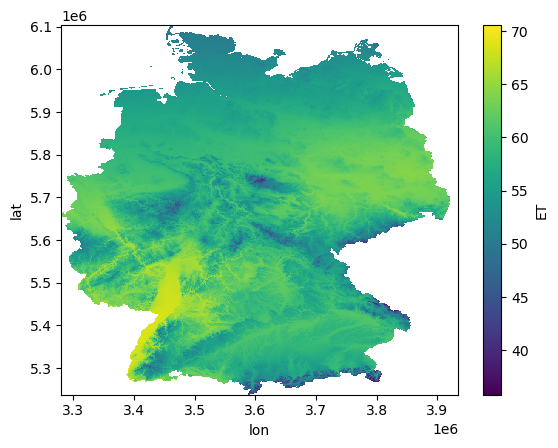

In [9]:
ET = et_merged.mean(dim='time')
ET.plot()


Apply Masks

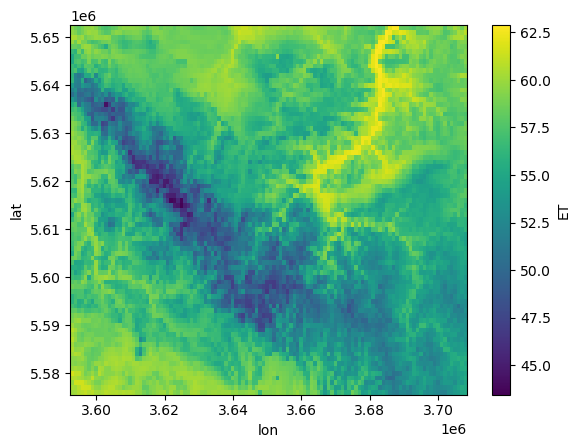

In [10]:

lon_min, lat_min, lon_max, lat_max = [10.294189,50.307024,11.961365,50.972242]
min_GK = UTM_to_Gauss_Kruger(lon_min, lat_min)
max_GK = UTM_to_Gauss_Kruger(lon_max, lat_max)
region_GK = (ET.lon >= min_GK[0]) & (ET.lat >= min_GK[1]) & (ET.lon <= max_GK[0]) & (ET.lat <= max_GK[1])

masked_ET = ET.where(region_GK).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
masked_ET.plot()